In [47]:
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV as GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)
pd.set_option("use_inf_as_na",True)
import folium

# Model Candidates

We are creating an estimator, so we are going to try several methods of regression.

* PolyGrid is our linear or polynomial regression with no subsetting or shrinkage.  

* RidgeGrid applies Ridge Regression, which works to reduce the coefficients of less influential features to focus on the most correlated ones.

* LassoGrid uses Lasso Regression to actually zero out the effect of less influential features, thereby reducing the number of features are considered for the model

* ElasticGrid combines the approaches of Ridge and Lasso regression

All of the below functions take a feature set X, and a target variable, Y, and return a GridSearchCV object.  GridSearchCV takes a regression estimator model, a scorer, and list of parameters.  It then tries the estimator on every combination of those parameters.  It also divides the data into 5 different cross-validation folds, or train/test sets, and stores the scores for each of the 5 tries according to the scoring method it is given (for each combination of hyperparameters).  So it creates a LOT of versions of each model and tries each one.  In my report table below I will be reporting the average cross-validation score across the 5 folds of the best model of each type of regression for each configuration of data.

## Linear Regression

In [20]:

#This function acts as a pipeline, taking data and degree of the polynomials, fitting and transforming it, fitting the estimator, and returns an optimal regression model based on an exhaustive gridsearch, and a mean cross validation score using mean squared error scoring
def PolyGrid(X,Y,degree):
    scoring = make_scorer(r2_score)
    n_jobs = 4
    iid = False
    cv = 5
    estimator = linear_model.LinearRegression()
    param_grid = {'fit_intercept':[True,False],'normalize':[True,False]}
    x_poly = preprocessing.StandardScaler(with_mean = False, with_std = False).fit_transform(X)
    if degree > 1:
        x_poly = preprocessing.PolynomialFeatures(degree).fit_transform(x_poly)
    regr = GridSearchCV(
        estimator = estimator,
        cv = cv,
        param_grid = param_grid,
        scoring = scoring,
        n_jobs = n_jobs,
        iid = iid)
    regr.fit(x_poly,Y)
    return regr

;

''

## Lasso Regression

In [21]:

#This function acts as a pipeline, taking data, fitting and transforming it, fitting the estimator, and returns an optimal regression model based on an exhaustive gridsearch, and a mean cross validation score using mean squared error scoring

def LassoGrid(X,Y):
    scoring = make_scorer(r2_score)
    n_jobs = 4
    iid = False
    cv = 5
    alphas=np.logspace(.01,200, 20)
    estimator = linear_model.Lasso()
    param_grid = {'alpha':alphas,'normalize':[True,False],'fit_intercept':[True,False],'positive':[True,False],'selection':['random','cyclic']}
    x_poly = preprocessing.StandardScaler(with_mean = False, with_std = True).fit_transform(X)
    regr = GridSearchCV(
        estimator = estimator,
        cv=cv,
        param_grid = param_grid,
        scoring = scoring,
        n_jobs = n_jobs,
        iid = iid)
    regr.fit(x_poly,Y)
    return regr

;

''

## Ridge Regression

In [22]:
#This function acts as a pipeline, taking data, fitting and transforming it, fitting the estimator, and returns an optimal regression model based on an exhaustive gridsearch, and a mean cross validation score using mean squared error scoring

def RidgeGrid(X,Y):
    scoring = make_scorer(r2_score)
    n_jobs = 4
    iid = False
    cv=5
    alphas=np.logspace(0,10,20)
    estimator = linear_model.Ridge()
    param_grid = {'alpha':alphas,'normalize':[True,False],'fit_intercept':[True,False],'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'saga']}
    x_poly = preprocessing.StandardScaler(with_mean = False, with_std = True).fit_transform(X)
    regr = GridSearchCV(
        estimator = estimator,
        cv=cv,
        param_grid = param_grid,
        scoring = scoring,
        n_jobs = n_jobs,
        iid = iid)
    regr.fit(x_poly,Y)
    return regr

;

''

## Elastic Net Regression

In [23]:
#This function acts as a pipeline, taking data, fitting and transforming it, fitting the estimator, and returns an optimal regression model based on an exhaustive gridsearch, and a mean cross validation score using mean squared error scoring

def ElasticGrid(X,Y):
    scoring = make_scorer(r2_score)
    n_jobs = 4
    iid = False
    cv=5
    max_iter = [2000]
    alphas=np.logspace(.01,200, 20)
    l1_ratio=np.linspace(0, 1, 10)
    estimator = linear_model.ElasticNet(fit_intercept = False, normalize= False)
    param_grid = {'max_iter':max_iter,'alpha':alphas,'normalize':[True,False],'positive':[True,False],'l1_ratio':l1_ratio, 'selection':['random','cyclic']}
    x_poly = preprocessing.StandardScaler(with_mean = False, with_std = True).fit_transform(X)
    regr = GridSearchCV(
        estimator = estimator,
        cv=cv,
        param_grid = param_grid,
        scoring = scoring,
        n_jobs = n_jobs,
        iid = iid)
    regr.fit(x_poly,Y)
    return regr

;

''

# Finding the right model and parameters

* I have a few different ideas about how my model could be made, and I want to compare all of those, and find the best hyperparameters.
* At the end I'll have a data frame of all of my experiments and the R2_score of each, as well as the optimal parameters.
* I'll try a Linear Regression, A Lasso Regression, a Ridge Regression, and an ElasticNet Regression.  Although, as a note, the Ridge Regression does not work when I drop the venues.  This is a known bug in the SciKit-Learn library, and the work around is not feasible within the scope of this project.  Hence, I will not test that configuration.
    * I tried higher order polynomial regressions, but with a feature set this large they are resource intensive.  Also, they tended to overfit pretty severely with this dataset.
* I'll try the four models with and without venues, and on a dataset with a reduced maximum sale price.  I chose to explore this last parameter because when I look at the regression plots for my predictions vs actual sale prices, I see that my predictions gain variance with higher value properties.

In [24]:
# @hidden cell
path ='C:\\Users\caell\OneDrive\Data Science Learning\Seattle Home Sales\Real Property Sales\seattle_home_sales.csv'

seattle_home_sales =pd.read_csv(path)
seattle_home_sales.shape

(4944, 171)

In [25]:
list(seattle_home_sales.columns)

['SalePrice',
 'SqFt1stFloor',
 'SqFtHalfFloor',
 'SqFt2ndFloor',
 'SqFtUpperFloor',
 'SqFtTotLiving',
 'SqFtTotBasement',
 'SqFtFinBasement',
 'SqFtGarageBasement',
 'SqFtGarageAttached',
 'DaylightBasement',
 'SqFtOpenPorch',
 'SqFtEnclosedPorch',
 'SqFtDeck',
 'BrickStone',
 'Bedrooms',
 'BathHalfCount',
 'Bath3qtrCount',
 'BathFullCount',
 'YrBuilt',
 'PcntComplete',
 'Longitude',
 'Latitude',
 'Golf Course',
 'Other Great Outdoors',
 'Elementary School',
 'General Entertainment',
 'Park',
 'Mexican Restaurant',
 'Vietnamese Restaurant',
 'Gas Station',
 'Housing Development',
 'Playground',
 'Pool',
 'Church',
 'Dive Bar',
 'Convenience Store',
 'Middle School',
 'Grocery Store',
 'Brewery',
 'Bar',
 'Salon / Barbershop',
 'Post Office',
 'Beach',
 'Lake',
 'Medical Center',
 'Sandwich Place',
 'Nail Salon',
 'Pizza Place',
 'Moving Target',
 'Building',
 'Preschool',
 'Library',
 'Trail',
 'Farm',
 'Community Center',
 'High School',
 'Gym / Fitness Center',
 'Bridge',
 'Gym',
 '

In [26]:

#Extract the Features
X = seattle_home_sales.drop(columns = ["SalePrice"])
#Extract the Targets
Y = seattle_home_sales['SalePrice']
#errorframe will hold our error reports for each model.
errorframe = pd.DataFrame(columns = ['Model','Mean Squared Error','R2 Score','Parameters'])
#We will fold our data 5 times for cross validation.
kf = KFold(n_splits=5)
#venues is a list of all the venue category feature columns.  We can use this list to easily make subsets of our data without venue information.
venues = ['Golf Course', 'Other Great Outdoors', 'Elementary School', 'General Entertainment', 'Park',
 'Mexican Restaurant', 'Vietnamese Restaurant', 'Gas Station', 'Housing Development', 'Playground',
 'Pool', 'Church', 'Dive Bar', 'Convenience Store', 'Middle School', 'Grocery Store', 'Brewery',
 'Bar', 'Salon / Barbershop', 'Post Office', 'Beach', 'Lake', 'Medical Center', 'Sandwich Place',
 'Nail Salon', 'Pizza Place', 'Moving Target', 'Building', 'Preschool', 'Library', 'Trail', 'Farm',
 'Community Center', 'High School', 'Gym / Fitness Center', 'Bridge', 'Gym', 'Supermarket', 'School',
 'Dance Studio', 'Athletics & Sports', 'Garden', 'Airport', 'Beer Bar', 'Dog Run', 'Pharmacy', 'Scenic Lookout',
 'Bank', 'Fast Food Restaurant', 'Miscellaneous Shop', 'Pet Store', "Doctor's Office", 'Pub', 'Coffee Shop',
 'Food Truck', 'Hardware Store', 'Bus Stop', 'Field', 'Laundry Service', "Dentist's Office", 'Bus Station',
 'Auto Dealership', 'Veterinarian', 'Tennis Court', 'Chinese Restaurant', 'Furniture / Home Store',
 'Bus Line', 'Café', 'Event Space', 'Italian Restaurant', 'Marijuana Dispensary', 'Office', 'Yoga Studio',
 'Restaurant', 'Baseball Field', 'Discount Store', 'Physical Therapist', 'American Restaurant', 'Martial Arts Dojo',
 'Spa', 'Storage Facility', 'Daycare', 'General Travel', 'Burger Joint', 'Pet Service', 'Thai Restaurant',
 'Chiropractor', 'Bakery', 'Mobile Phone Shop', 'Ice Cream Shop', 'Automotive Shop', 'Assisted Living',
 'Health & Beauty Service', 'Fried Chicken Joint', 'Taco Place', 'Video Store', 'Financial or Legal Service',
 'Massage Studio', 'Asian Restaurant', 'Insurance Office', 'Japanese Restaurant', 'ATM', 'Locksmith',
 'Shipping Store']
X.head()

,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,PcntComplete,Longitude,Latitude,Golf Course,Other Great Outdoors,Elementary School,General Entertainment,Park,Mexican Restaurant,Vietnamese Restaurant,Gas Station,Housing Development,Playground,Pool,Church,Dive Bar,Convenience Store,Middle School,Grocery Store,Brewery,Bar,Salon / Barbershop,Post Office,Beach,Lake,Medical Center,Sandwich Place,Nail Salon,Pizza Place,Moving Target,Building,Preschool,Library,Trail,Farm,Community Center,High School,Gym / Fitness Center,Bridge,Gym,Supermarket,School,Dance Studio,Athletics & Sports,Garden,Airport,Beer Bar,Dog Run,Pharmacy,Scenic Lookout,Bank,Fast Food Restaurant,Miscellaneous Shop,Pet Store,Doctor's Office,Pub,Coffee Shop,Food Truck,Hardware Store,Bus Stop,Field,Laundry Service,Dentist's Office,Bus Station,Auto Dealership,Veterinarian,Tennis Court,Chinese Restaurant,Furniture / Home Store,Bus Line,Café,Event Space,Italian Restaurant,Marijuana Dispensary,Office,Yoga Studio,Restaurant,Baseball Field,Discount Store,Physical Therapist,American Restaurant,Martial Arts Dojo,Spa,Storage Facility,Daycare,General Travel,Burger Joint,Pet Service,Thai Restaurant,Chiropractor,Bakery,Mobile Phone Shop,Ice Cream Shop,Automotive Shop,Assisted Living,Health & Beauty Service,Fried Chicken Joint,Taco Place,Video Store,Financial or Legal Service,Massage Studio,Asian Restaurant,Insurance Office,Japanese Restaurant,ATM,Locksmith,Shipping Store,BldgGrade_4,BldgGrade_5,BldgGrade_6,BldgGrade_7,BldgGrade_8,BldgGrade_9,BldgGrade_10,BldgGrade_11,BldgGrade_12,FinBasementGrade_3,FinBasementGrade_4,FinBasementGrade_5,FinBasementGrade_6,FinBasementGrade_7,FinBasementGrade_8,FinBasementGrade_9,FinBasementGrade_10,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,HeatSystem_8,Condition_2,Condition_3,Condition_4,Condition_5,MonthSold_02,MonthSold_03,MonthSold_04,MonthSold_05,MonthSold_06,MonthSold_07,MonthSold_08,MonthSold_09,MonthSold_10,MonthSold_11,MonthSold_12,YearSold_2017,YearSold_2018,YearSold_2019,YearSold_2020
0,1590,0,0,0,3180,1590,1590,0,600,1,50,0,220,0,6,0,2,1,1965,0,-122.196399,47.336118,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,1390,0,0,0,2200,810,810,0,0,1,0,0,340,0,4,1,0,1,1945,0,-122.361913,47.509874,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1010,0,1515,0,2525,0,0,0,400,0,167,0,0,0,4,1,0,2,2019,0,-122.156684,47.437557,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,660,0,540,0,1820,620,620,0,0,1,0,0,100,0,3,1,0,2,2016,0,-122.370252,47.565146,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,2310,0,0,0,2310,0,0,0,440,0,40,0,320,0,3,0,0,2,1967,0,-122.184194,47.730389,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Full Dataset Modeling 
Below we will actually try thousands of different ways to model this data, and pick the ones that are most accurate.  The below code will produce a table of different regression types, with and without venue information, and the best case scores for a wide range of parameters for that model type.

In [27]:
# novens is a subset of our feature set, X, without the venue category columns.
novens = X.drop(columns=venues)

In [28]:
#Linear Regression with venue data
regr = PolyGrid(X,Y,1)
yhat = regr.predict(X)
errorframe = errorframe.append({'Model':'GridSearch baseline Linear Regression with venues','Mean Squared Error':mean_squared_error(Y,yhat),'R2 Score':regr.best_score_, 'Parameters':regr.best_params_},ignore_index=True)

#Linear Regression without venue data
regr = PolyGrid(novens,Y,1)
yhat = regr.predict(novens)
errorframe = errorframe.append({'Model':'GridSearch baseline Linear Regression without venues','Mean Squared Error':mean_squared_error(Y,yhat),'R2 Score':regr.best_score_, 'Parameters':regr.best_params_},ignore_index=True)

#Lasso Regression with venue data
regr = LassoGrid(X,Y)
yhat = regr.predict(X)
errorframe = errorframe.append({'Model':'GridSearch baseline Lasso Regression with venues','Mean Squared Error':mean_squared_error(Y,yhat),'R2 Score':regr.best_score_, 'Parameters':regr.best_params_},ignore_index=True)

#Lasso Regression without venue data
regr = LassoGrid(novens,Y)
yhat = regr.predict(novens)
errorframe = errorframe.append({'Model':'GridSearch baseline Lasso Regression without venues','Mean Squared Error':mean_squared_error(Y,yhat),'R2 Score':regr.best_score_, 'Parameters':regr.best_params_},ignore_index=True)

#Ridge Regression with venue data
regr = RidgeGrid(X,Y)
yhat = regr.predict(X)
errorframe = errorframe.append({'Model':'GridSearch baseline Ridge Regression with venues','Mean Squared Error':mean_squared_error(Y,yhat),'R2 Score':regr.best_score_, 'Parameters':regr.best_params_},ignore_index=True)

#Ridge Regression without venue data
regr = RidgeGrid(novens,Y)
yhat = regr.predict(novens)
errorframe = errorframe.append({'Model':'GridSearch baseline Ridge Regression without venues','Mean Squared Error':mean_squared_error(Y,yhat),'R2 Score':regr.best_score_, 'Parameters':regr.best_params_},ignore_index=True)

#Elastic Net Regression with venue data
regr = ElasticGrid(X,Y)
yhat = regr.predict(X)
errorframe = errorframe.append({'Model':'GridSearch baseline ElasticNet Regression with venues','Mean Squared Error':mean_squared_error(Y,yhat),'R2 Score':regr.best_score_, 'Parameters':regr.best_params_},ignore_index=True)
errorframe

#Elastic Net Regression without venue data
regr = ElasticGrid(novens,Y)
yhat = regr.predict(novens)
errorframe = errorframe.append({'Model':'GridSearch baseline ElasticNet Regression without venues','Mean Squared Error':mean_squared_error(Y,yhat),'R2 Score':regr.best_score_, 'Parameters':regr.best_params_},ignore_index=True)

errorframe

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264808391994.45312, tolerance: 43839282311.84861
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1332080163035.0625, tolerance: 43839282311.84861
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89024096176984.64, tolerance: 262047945147.30463
  positive)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108238619156110.02, tolerance: 262047945147.3

,Model,Mean Squared Error,R2 Score,Parameters
0,GridSearch baseline Linear Regression with venues,2.813172e+10,0.650270,"{'fit_intercept': True, 'normalize': True}"
1,GridSearch baseline Linear Regression without venues,3.207789e+10,0.620564,"{'fit_intercept': True, 'normalize': False}"
2,GridSearch baseline Lasso Regression with venues,6.250191e+15,0.650624,"{'alpha': 1.023292992280754, 'fit_intercept': True, 'normalize': True, 'positive': False, 'selec..."
3,GridSearch baseline Lasso Regression without venues,4.578111e+15,0.620825,"{'alpha': 1.023292992280754, 'fit_intercept': True, 'normalize': True, 'positive': False, 'selec..."
4,GridSearch baseline Ridge Regression with venues,7.733765e+15,0.650710,"{'alpha': 127.42749857031335, 'fit_intercept': False, 'normalize': True, 'solver': 'svd'}"
5,GridSearch baseline Ridge Regression without venues,4.627266e+15,0.620804,"{'alpha': 3.3598182862837818, 'fit_intercept': True, 'normalize': False, 'solver': 'sparse_cg'}"
6,GridSearch baseline ElasticNet Regression with venues,3.180982e+16,0.554088,"{'alpha': 1.023292992280754, 'l1_ratio': 1.0, 'max_iter': 2000, 'normalize': True, 'positive': F..."
7,GridSearch baseline ElasticNet Regression without venues,8.975419e+15,0.484036,"{'alpha': 1.023292992280754, 'l1_ratio': 1.0, 'max_iter': 2000, 'normalize': False, 'positive': ..."


## Model Testing 1
Our most accurate models are the straight Linear Regressions.  The linear regressions produced the lowest MSEs by 5 orders of magnitude and accounted for 61-62% of the variance in actual price.  With venues the model was able to predict about 61% of the variance in the price, while without venues modeled slightly more at 62%.  However, the model without venues also had a slightly higher total MSE.  

Other models had MSEs of many orders of magnitude greater.  Since MSE penalizes individual large errors more than smaller errors, this leads me to believe that the other models, while not necessarily predictively weaker, were more prone to large errors.

The differences are not significant, though.  My conclusion here is that the venue data makes no real significant difference to our model, so far.

However, let's look deeper at how our predictions compare to the actual saleprices.

In [29]:
regr = PolyGrid(X,Y,1)
yhat = regr.predict(X)
print('MSE = ',mean_squared_error(Y,yhat),' R2 Score = ',regr.best_score_)

MSE =  28131722742.189953  R2 Score =  0.6502699067279677


Text(0.5, 0, 'Actual Sale Price')

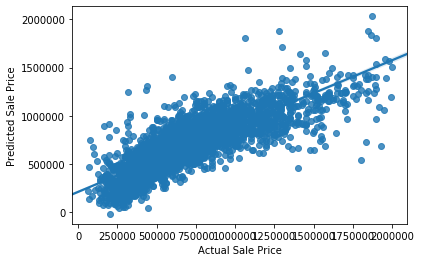

In [30]:
sns.regplot(Y,yhat)
plt.ylabel('Predicted Sale Price')
plt.xlabel('Actual Sale Price')

The above graph plots each parcel's actual sale price against the model's predicted value.  The line through the middle shows the regression line, the line that minimizes the total distance between points.  

The plot shows that my model's predictions generally follow the actual price.  My model generally predicts higher prices for homes that sold more.  The dots that are far from the regression line show outliers, or homes that sold for much different prices than my model predicted.  I see the fewest outliers between 500,000 and about $1,250,000.

On the right side of the plot we see a wide scattering of samples.  This shows me that my model is badly predicting many of the samples over about \$1,750,000.  Let's see if we can improve our model by only considering samples under that price.  Maybe higher priced homes play by different rules.

# Analysis

As we can see from the above report, our best model is a multiple linear regression.  Venue data did not significantly change the accuracy.

The result of the experiment is on average, local venues are not predictive of home prices, and are not worth including in a predictive model of the Seattle residential retail market.

However, let's see what insights we can gain from our best model.  I'll choose to include venues, just to see if there are some venues that have an impact on home prices, according to our model.

In [31]:
errorframe

,Model,Mean Squared Error,R2 Score,Parameters
0,GridSearch baseline Linear Regression with venues,2.813172e+10,0.650270,"{'fit_intercept': True, 'normalize': True}"
1,GridSearch baseline Linear Regression without venues,3.207789e+10,0.620564,"{'fit_intercept': True, 'normalize': False}"
2,GridSearch baseline Lasso Regression with venues,6.250191e+15,0.650624,"{'alpha': 1.023292992280754, 'fit_intercept': True, 'normalize': True, 'positive': False, 'selec..."
3,GridSearch baseline Lasso Regression without venues,4.578111e+15,0.620825,"{'alpha': 1.023292992280754, 'fit_intercept': True, 'normalize': True, 'positive': False, 'selec..."
4,GridSearch baseline Ridge Regression with venues,7.733765e+15,0.650710,"{'alpha': 127.42749857031335, 'fit_intercept': False, 'normalize': True, 'solver': 'svd'}"
5,GridSearch baseline Ridge Regression without venues,4.627266e+15,0.620804,"{'alpha': 3.3598182862837818, 'fit_intercept': True, 'normalize': False, 'solver': 'sparse_cg'}"
6,GridSearch baseline ElasticNet Regression with venues,3.180982e+16,0.554088,"{'alpha': 1.023292992280754, 'l1_ratio': 1.0, 'max_iter': 2000, 'normalize': True, 'positive': F..."
7,GridSearch baseline ElasticNet Regression without venues,8.975419e+15,0.484036,"{'alpha': 1.023292992280754, 'l1_ratio': 1.0, 'max_iter': 2000, 'normalize': False, 'positive': ..."


## Accuracy
Let's first take a look at the accuracy of our model.  I chose to use model 0, a multiiple linear regression model with the venue data.  The mean squared error for that model is 2,820,000,000, and the R2 Score is .60.  This means that the model can account for about 60% of the variance of the sale prices and the squared error is almost 2 billion.  That sounds like a lot, but let's look below to see what the actual average error is.

The first thing I'll do is create a dataframe of the actual sale prices (Y), the prices my model predicts, and the difference between them.

In [48]:
#Create the estimator
regr = PolyGrid(X,Y,1).best_estimator_
#Create the DataFrame
yhat = regr.predict(X)
errors = pd.DataFrame({'Actual':Y,'Predicted': pd.Series(yhat).astype(int), 'Error': (yhat - Y).astype(int)})
errors

,Actual,Predicted,Error
0,400000,578832,178832
1,474250,570258,96008
2,667950,686316,18366
3,659000,679045,20045
4,656500,684597,28097
...,...,...,...
4939,805000,731596,-73403
4940,855000,868112,13112
4941,655000,817019,162019
4942,930000,878553,-51446


The model's predictions are generally within the right ballpark, and some are quite close!  Let's look at the average error.

In [38]:
print('The mean error is: ', errors['Error'].abs().mean())

The mean error is:  117191.09263754045


The model is off by an average of 117,000 dollars per parcel.  That's not great.  This would not be a good model for actually trying to decide how to price your home correctly.  However, it does have some validity, so it can tell us some things about the Seattle housing market.

Let's see how bad an error of 117,000 really is.

In [44]:
print('The average sale prices is: ', errors['Actual'].abs().mean())
print('So, the model errors, on average, by: ', errors['Error'].abs().mean() / errors['Actual'].abs().mean())

The average sale prices is:  664349.7301779935
So, the model errors, on average, by:  0.17639969930618088


Are there certain regions that the model struggles to capture?  Does that account for the error rate?

Below is a map of the home sales that account for the 100 largest errors the model made in predictions.  I see that our model especially struggled to predict home prices in Bellevue along the lake.  

In [40]:
#higherrors is a dataframe of the 100 largest errors in the errors dataframe.
higherrors = errors.abs().sort_values(by='Error',ascending=False).head(100)
higherrors = higherrors.join(errors['Error'], how = 'inner',rsuffix = 'actual',).drop(columns=['Error'])
higherrors = higherrors.rename({'Erroractual':'Error'})
mapper=higherrors.join(X,how='inner',on=higherrors.index)
#Initiate the map centered on Seattle
seattle_map = folium.Map(location=[47.56,-122.4], zoom_start=9)

#Populate the map with markers for every 100th sample in our dataset 
for index, row in mapper.iterrows():
    folium.Marker([row['Latitude'],row['Longitude']],
       popup = ['Predicted: ' + str(row['Predicted']), 'Actual: '+ str(row['Actual']), 
              'Difference: ' + str(row['Erroractual']), 'index', row[0]],
                 icon=folium.Icon(icon='cloud',icon_color='black',color='red')).add_to(seattle_map)


seattle_map

By clicking on the markers, I'm seeing a lot of those errors are underestimations.  Let's see what our average error is in Bellevue.

In [45]:
#Extract Features for Homes east of the lake
EastX = seattle_home_sales[seattle_home_sales['Longitude'] > -122.271022].reset_index()

#Extract Targets for Homes east of the lake
EastY = EastX['SalePrice']
EastX = EastX.drop(columns=['SalePrice','index'])

#Make a prediction with our model and test the accuracy
yhat = regr.predict(EastX)
easterrors = pd.DataFrame({'Actual':EastY,'Predicted': yhat, 'Error': EastY-yhat})
print('Average Errors East of the Lake are: ', easterrors['Error'].abs().mean())
easterrors

Average Errors East of the Lake are:  128863.55816156368


,Actual,Predicted,Error
0,400000,5.788322e+05,-178832.183577
1,667950,6.863161e+05,-18366.105028
2,656500,6.845979e+05,-28097.855439
3,675000,7.185240e+05,-43524.034063
4,415000,7.064833e+05,-291483.313735
...,...,...,...
1990,934939,9.037797e+05,31159.313981
1991,608000,6.403735e+05,-32373.523315
1992,550000,5.179157e+05,32084.298311
1993,655000,8.170193e+05,-162019.267429


The average error over our entire dataset is 117k, but east of the lake it's 128k.  Our model loses accuracy when considering homes in Bellevue.  Let's check this assumption by modelling just the homes west of the lake.

In [46]:
#Extract features and targets for homes west of the lake.
WestX = seattle_home_sales[seattle_home_sales['Longitude']<-122.271022]
WestY = WestX['SalePrice']
WestX = WestX.drop(columns=['SalePrice'])

#make predictions for homes west of the lake
yhat = regr.predict(WestX)
westerrors = pd.DataFrame({'Actual':WestY,'Predicted': yhat,'Error':WestY-yhat})
print('Average Error: ', westerrors['Error'].abs().mean())
westerrors

Average Error:  109295.4978384639


,Actual,Predicted,Error
1,474250,570258.527241,-96008.527241
3,659000,679045.490016,-20045.490016
7,160000,461323.508652,-301323.508652
8,299000,246482.224623,52517.775377
9,1210000,911040.288398,298959.711602
...,...,...,...
4936,530000,499103.333217,30896.666783
4937,442000,673439.845023,-231439.845023
4939,805000,731596.503084,73403.496916
4940,855000,868112.834261,-13112.834261


We can better model just the homes west of the lake, but it's common for people who work in Seattle to buy homes in Bellevue and commute over the bridges.  Our model is able to explain 62% of the variance, over 60% for the model of both sides, and the mean squared error drops to 2.3 billion from 2.8 billion.  Finally, the average error drops from 117k to 109k.

It seems that these two markets may play some somewhat different rules.  However, I'll leave those samples in my model, because I want my model to have validity for any families buying a home within commuting distance of Seattle.

# Decode tables for HeatSystem, BldgGrade, FinBasementGrade, and condition

|**HeatSystem**| **BldgGrade and FinBasementGrade** | **Condition**
|:-----------|:-----:|:---
|0	Unknown| | 
|1	Electric| 3 Poor | 1 Poor|
|2	Electric wall| 4 Low	| 2 Fair|
|3	Forced air unit|5 Fair| 3 Average|
|4	Hot water|6 Low	Average| 4 Good|
|5	Hot water-radiant|	7 Average|	5 Very Good|
|7	Steam|8 Good|
|8	Steam without boiler|9 Better|
||	10 Very Good|
||11 Excellent|
||12 Luxury|


In [50]:
regr = PolyGrid(X,Y,1).best_estimator_
coefs = pd.DataFrame({'Features':X.columns,'Coefficients':regr.coef_}).sort_values(by='Coefficients',ascending=False)
coefs

,Features,Coefficients
21,Latitude,800788.696148
134,BldgGrade_12,618781.573251
133,BldgGrade_11,470597.915641
132,BldgGrade_10,351864.018568
142,FinBasementGrade_10,333620.948439
20,Longitude,279757.442907
154,Condition_5,203528.509416
131,BldgGrade_9,194517.114071
153,Condition_4,166493.078317
167,YearSold_2018,145020.835890


## Interpreting the model
The wonderful thing about multiple linear regressions are that they are very transparent in how they make their predictions.  The coefficients that the model assigns to each feature represent the positive or negative weight that the model puts on those features.  Higher values in features assigned positive coefficients drive the predicted price up, while negative ones drive it down.

### Latitude and Longitude
Despite proving the null hypothesis, our model has some insights to share.  The biggest determinate of SalePrice, according to our model, is Latitude.  This is something we say before with simple correspondence between the variables.  This is also something I've consistently seen in the various versions of this model I've explored.  In Seattle, the latitude you live at is the biggest determiner of the value of our home.

Anyone living in Seattle, as I do, is not surprised by this fact.  South Seattle, which, of course, has the lower latitudes, is known to be a lower income area.  As previous maps have shone, the most valuable houses make a cross along the lake shores.  

Longitude is the 6th most influential feature.  This corresponds to the North/South band of high prices homes along the lake, especially on the west side shore.

### Building Grade, Condition, and Finished Basement Grade
`BldgGrade`, `Condition` and `FinBasementGrade` or building grade, current home condition, and finished basement grade are our next most influential features.  These represent the quality of materials and construction of a building.  We can see that home buyers prefer building and basement grades 10-12, correspond to 'Very Good', 'Excellent', and 'Luxury', respectively.  This an unsurprising revelation, but it lends credence to the validity of our model.  They also prefer homes in better condition (condition goes from 1 to 5, with higher numbers being better conditions).  On the negative end of the coefficients we see lower values of `BldgGrade`, corresponding to less well build homes.

### Venues
While the effect of local venues was slight, our model does have some interesting insights about what people like to live around, or at least what correlates to pricer homes.  Lakes, schools, chiropractors, and...video stores(?) are associated with higher priced homes, while cemetaries, ice cream stores(!?), laundry services, and auto dealerships are associated with lower priced homes.

# Conclusion

My goal was to explore whether information about local venues could improve estimates of home sale prices.  I found that they are not useful for this.  While there was some effect that some venues had on prices, even those effects were slight and overshadowed by other aspects.  While venues don't play a large part in the price of homes, location, size, build quality, and condition do significantly influence home prices.

My other finding is that home prices are hard to model!  There was a lot of variance that my model could not account for, and many homes that it predicted wildly different prices.  For some samples I questioned the prediction of the model, others were truly outliers, as far as I could see.  Some homes sold for inexplicable prices that do not seem to match location, size, or quality.

My guess is that if I included more information about homes in the nearby neighborhood, that I could improve my model.  My model does not take into account current market conditions, or put extra weight on saleprices of nearby homes.  It would be interesting to look at average home prices correlated to nearby venues within a neighborhood, rather than going sale by sale.  One could discover what kinds of venues are in pricier neighborhoods vs low cost neighborhoods.  My model shows some of those correlations, such as lower cost homes are associated with cemetaries and laundry services, and that higher prices homes associate with lakes and schools.  It's reasonable to suppose that those venues are located in neighborhoods with higher average home values, but there are better ways to explore that hypothesis.